Universidad del Valle de Guatemala

Métodos Numéricos

Proyecto final de curso

Integrantes: 

Aldo Ávila, Luis Pablo Carranza, Carlos Julio Valdés, Oscar Donis, Carlos Molina

# Reconocimiento de canciones con la FFT y coeficientes MFCC

El código funciona adecuadamente con trozos de las canciones originales, con canciones grabas en otros dispositivos la calidad del audio puede influir en que no las reconozca correctamente.

Los archivos de pureba son los siguientes:

* test 6: Don't stop me now
* test 7: Simple minds - don't you 
* test 8: Sandman
* test 9: Zelda
* test 10: Here comes the sun
* test 11: Everybody wants 

In [1]:
# Importar todas las librerías a utilizar
import numpy as np
from scipy.io import wavfile
from scipy.fftpack import fft
from scipy.signal import butter, lfilter
from python_speech_features import mfcc
import os
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Función para crear un filtro de Butterworth de paso bajo
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    # Coeficientes del filtro de Butterworth
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

In [3]:
# Función para aplicar un filtro de paso bajo a una señal de audio
def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    # Aplicar el filtro a la señal de audio
    y = lfilter(b, a, data)
    return y

In [4]:
# Función para normalizar una señal de audio
def normalize_audio(audio_data):
    max_val = np.max(np.abs(audio_data))
    if max_val == 0:
        return audio_data
    # Normalizar la señal dividiéndola por su valor máximo absoluto
    return audio_data / max_val


In [5]:

# Función para obtener las frecuencias principales (fingerprint) de una señal de audio
def get_fingerprint(segment, sample_rate, num_peaks=10):
    # Realizar la Transformada Rápida de Fourier (FFT) en el segmento de audio
    audio_fft = fft(segment)
    # Calcular las frecuencias correspondientes a la FFT
    freqs = np.fft.fftfreq(len(segment), d=1/sample_rate)
    # Obtener las magnitudes de los componentes de frecuencia
    magnitudes = np.abs(audio_fft)
    # Seleccionar las 'num_peaks' frecuencias principales con las magnitudes más altas
    peaks = np.argsort(magnitudes)[-num_peaks:]
    # Obtener las frecuencias correspondientes a los picos seleccionados
    fingerprint = freqs[peaks]
    # Devolver las frecuencias principales como fingerprint
    return fingerprint

# Función para extraer los coeficientes MFCC de una señal de audio
def get_mfcc(segment, sample_rate):
    # Calcular los coeficientes MFCC de la señal de audio
    mfcc_features = mfcc(segment, sample_rate, numcep=13, nfft=1200)
    # Devolver los coeficientes MFCC calculados
    return mfcc_features


In [6]:
# Función para dividir un archivo de audio en segmentos
def split_audio(file_path, segment_duration, overlap=0.5):
    sample_rate, audio_data = wavfile.read(file_path)
    # Convertir el audio a mono
    audio_data = audio_data.mean(axis=1)
    # Aplicar un filtro de paso bajo al audio
    audio_data = lowpass_filter(audio_data, cutoff=8000, fs=sample_rate)
    # Normalizar el audio
    audio_data = normalize_audio(audio_data)
    n = len(audio_data)
    segment_length = int(segment_duration * sample_rate)
    overlap_length = int(segment_length * overlap)
    # Dividir el audio en segmentos con un solapamiento dado
    segments = [audio_data[i:i+segment_length] for i in range(0, n - overlap_length, segment_length - overlap_length)]
    return segments, sample_rate, segment_length


In [7]:
# Función para crear una base de datos de archivos de audio
def create_database(audio_files_directory, segment_duration=0.5, overlap=0.5, num_peaks=10):
    database = {}
    for filename in os.listdir(audio_files_directory):
        if filename.endswith(".wav"):
            file_path = os.path.join(audio_files_directory, filename)
            # Dividir el archivo de audio en segmentos
            segments, sample_rate, segment_length = split_audio(file_path, segment_duration, overlap)
            fingerprints = []
            mfccs = []
            for i, segment in enumerate(segments):
                if len(segment) == segment_length:
                    # Calcular las características de la señal de audio (fingerprint y MFCC)
                    fingerprint = get_fingerprint(segment, sample_rate, num_peaks)
                    mfcc_features = get_mfcc(segment, sample_rate)
                    # Guardar los fingerprints y MFCC de cada segmento
                    fingerprints.append(fingerprint)
                    mfccs.append(mfcc_features)
                    # Almacenar las características en la base de datos
                    mfcc_features = mfcc_features.mean(axis=0)
                    database[f"{filename}_{i}"] = (fingerprint, mfcc_features)
            # Graficar los fingerprints y MFCC de la canción
            plot_features(filename, fingerprints, mfccs)
    return database

In [8]:
# Función para graficar los fingerprints y los coeficientes MFCC de una canción
def plot_features(filename, fingerprints, mfccs):
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    fig.suptitle(f"Features of {filename}", fontsize=16)
    axes[0].set_title("Fingerprints")
    axes[0].set_xlabel("Index")
    axes[0].set_ylabel("Frequency (Hz)")
    concatenated_fingerprints = np.concatenate(fingerprints)
    axes[0].plot(concatenated_fingerprints)
    axes[1].set_title("MFCC")
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel("MFCC Coefficient")
    # Promediar los coeficientes MFCC a lo largo de los segmentos
    averaged_mfccs = np.mean(mfccs, axis=1)
    sns.heatmap(np.transpose(averaged_mfccs), ax=axes[1], cmap="viridis")
    plt.tight_layout()
    plt.show()

In [9]:
# Función para encontrar la mejor coincidencia en la base de datos
def find_match(query_file, database, segment_duration=0.5, overlap=0.5, num_peaks=10):
    # Dividir el archivo de audio de consulta en segmentos con una duración y solapamiento especificados
    segments, sample_rate, segment_length = split_audio(query_file, segment_duration, overlap)
    
    # Inicializar listas para almacenar las huellas digitales (fingerprints) y coeficientes MFCC de la consulta
    query_fingerprint_all = []
    query_mfcc_all = []
    
    # Inicializar variables para rastrear la mejor coincidencia y la mejor puntuación (score)
    best_match = None
    best_score = float('inf')  # Se usa infinito como valor inicial para la mejor puntuación
    
    # Procesar cada segmento del archivo de consulta
    for segment in segments:
        # Solo procesar el segmento si su longitud coincide con la longitud esperada
        if len(segment) == segment_length:
            # Calcular las características del segmento de consulta
            query_fingerprint = get_fingerprint(segment, sample_rate, num_peaks)
            query_mfcc = get_mfcc(segment, sample_rate)
            
            # Almacenar las características calculadas
            query_fingerprint_all.append(query_fingerprint)
            query_mfcc_all.append(query_mfcc)
            
            # Calcular el promedio de los coeficientes MFCC a lo largo del tiempo (axis=0)
            query_mfcc = query_mfcc.mean(axis=0)
            
            # Comparar las características de la consulta con cada entrada en la base de datos
            for db_key, (db_fingerprint, db_mfcc) in database.items():
                # Calcular la diferencia absoluta entre las huellas digitales de la consulta y la base de datos
                score_fingerprint = np.sum(np.abs(db_fingerprint - query_fingerprint))
                
                # Calcular la diferencia absoluta entre los coeficientes MFCC de la consulta y la base de datos
                score_mfcc = np.sum(np.abs(db_mfcc - query_mfcc))
                
                # Calcular la puntuación total como la suma de las diferencias de huellas digitales y MFCC
                total_score = score_fingerprint + score_mfcc
                
                # Actualizar la mejor coincidencia si la puntuación total actual es menor que la mejor puntuación encontrada
                if total_score < best_score:
                    best_score = total_score
                    best_match = db_key
    
    # Graficar las características de la consulta (opcional)
    plot_features(query_file, query_fingerprint_all, query_mfcc_all)
    
    # Devolver la clave de la mejor coincidencia encontrada en la base de datos
    return best_match




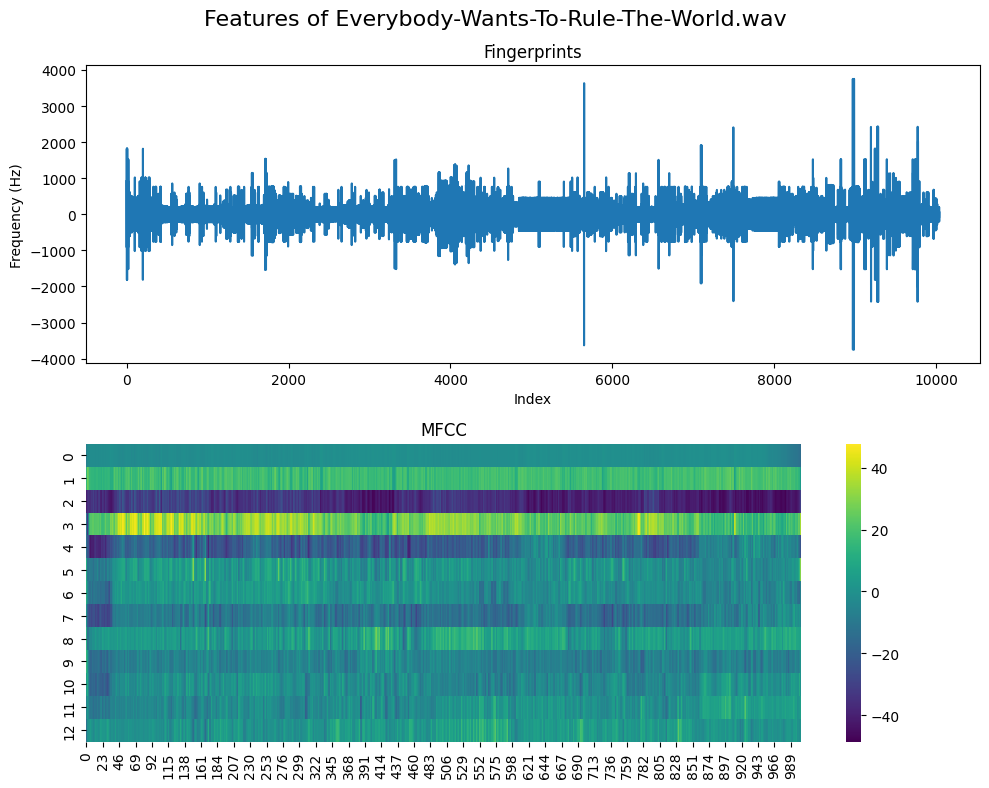

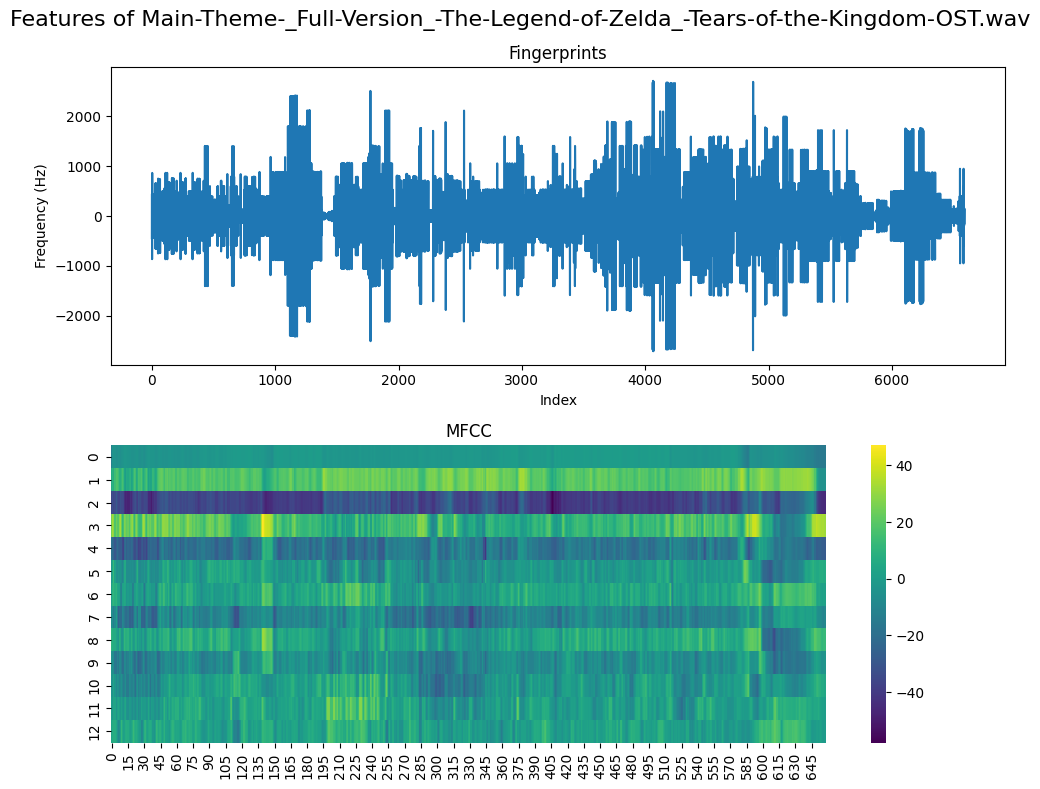

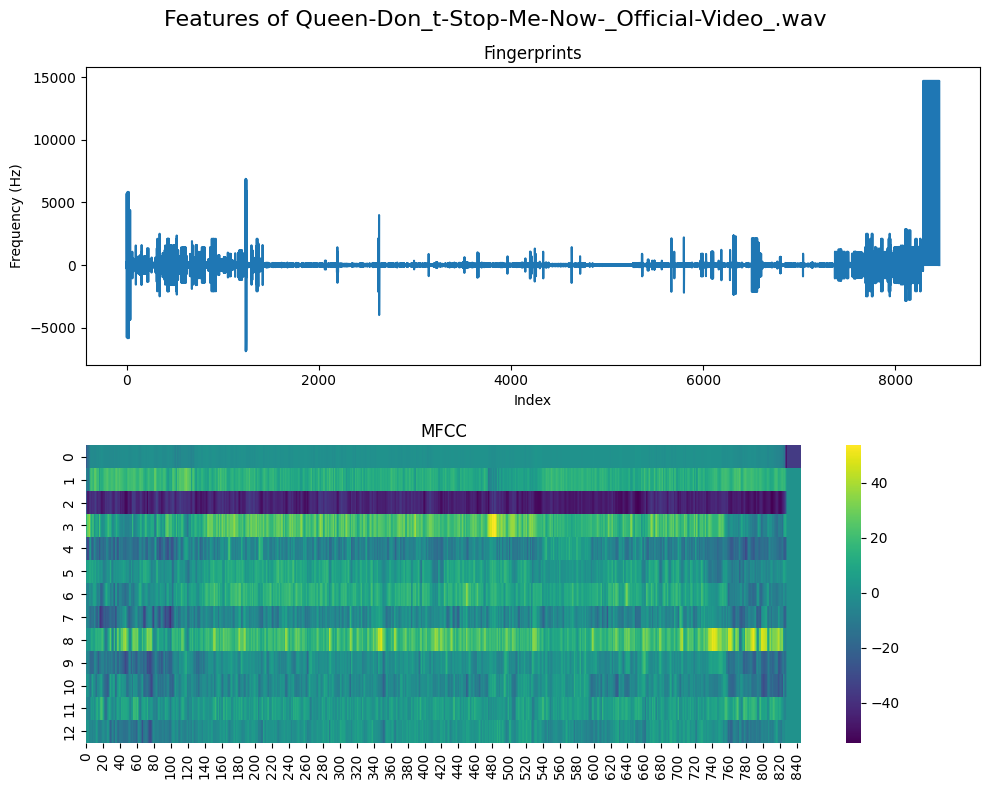

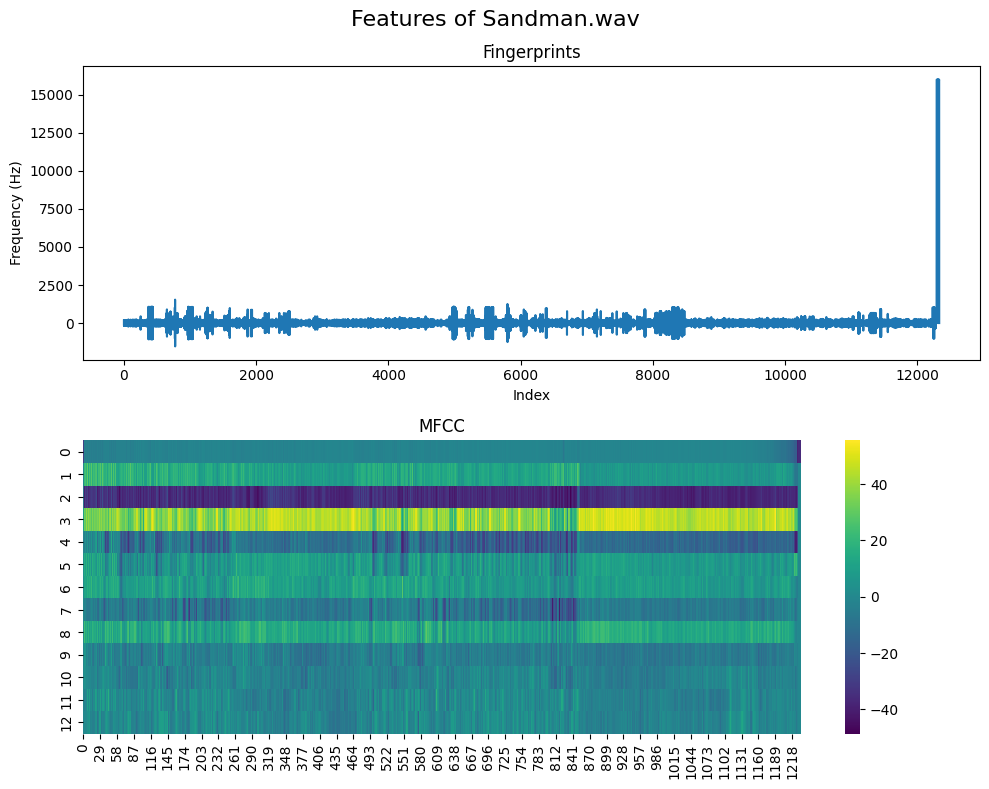

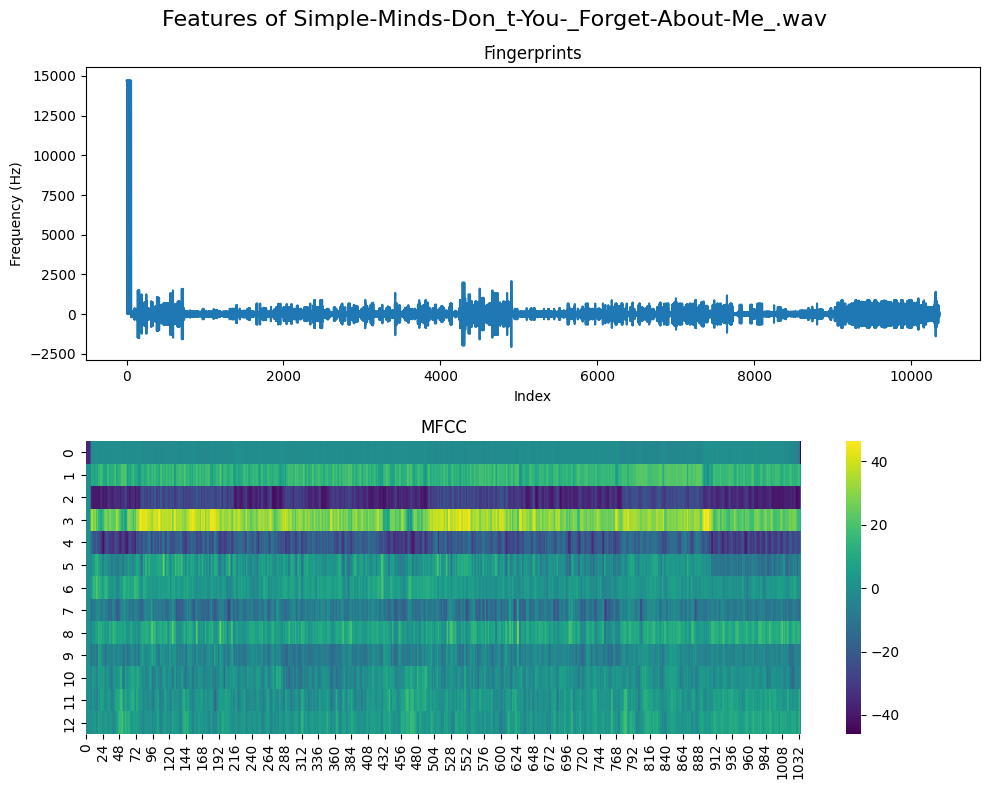

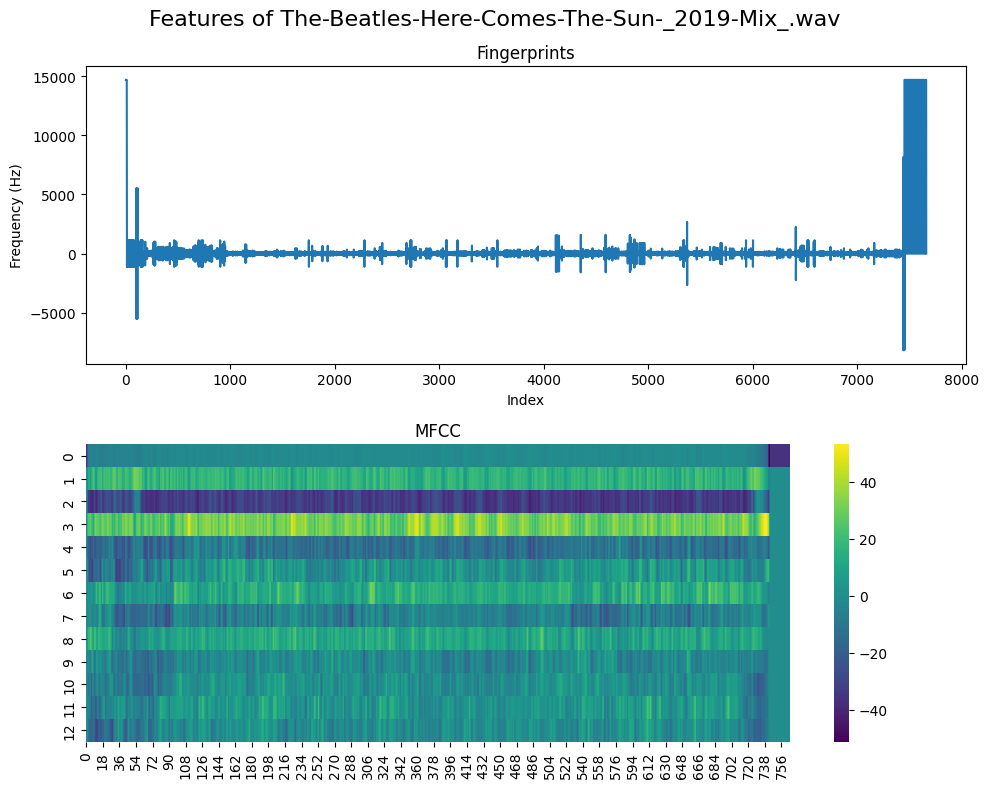

In [10]:
# Directorio que contiene los archivos de audio
audio_files_directory = r'D:\Pablo\OneDrive - UVG\Clases U\Semestre VII\Métodos Numéricos\Proyecto 3\Songs'
# Crear la base de datos de archivos de audio
database = create_database(audio_files_directory, segment_duration=0.5, overlap=0.5, num_peaks=10)



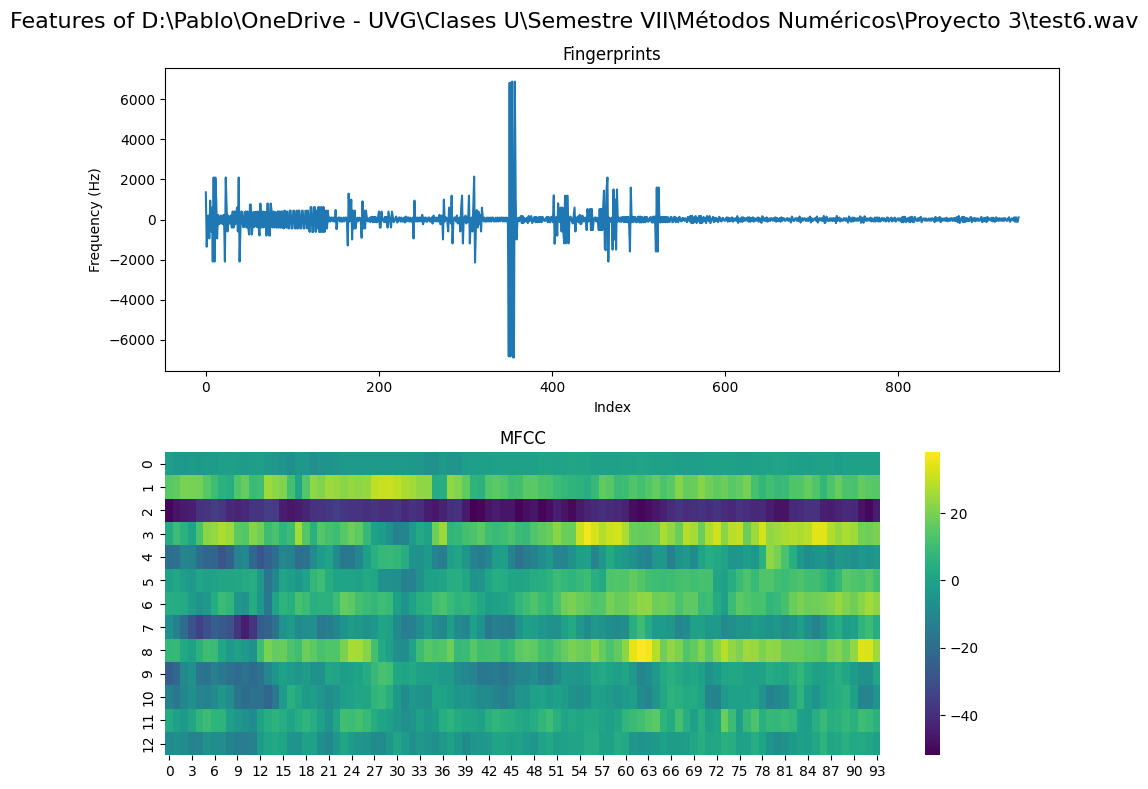

La mejor coincidencia es: Queen-Don_t-Stop-Me-Now-_Official-Video_.wav_96


In [11]:
# Archivo de audio de consulta
query_file = r'D:\Pablo\OneDrive - UVG\Clases U\Semestre VII\Métodos Numéricos\Proyecto 3\test6.wav'
# Encontrar la mejor coincidencia en la base de datos para el archivo de consulta
match = find_match(query_file, database, segment_duration=0.5, overlap=0.5, num_peaks=10)
print(f"La mejor coincidencia es: {match}")

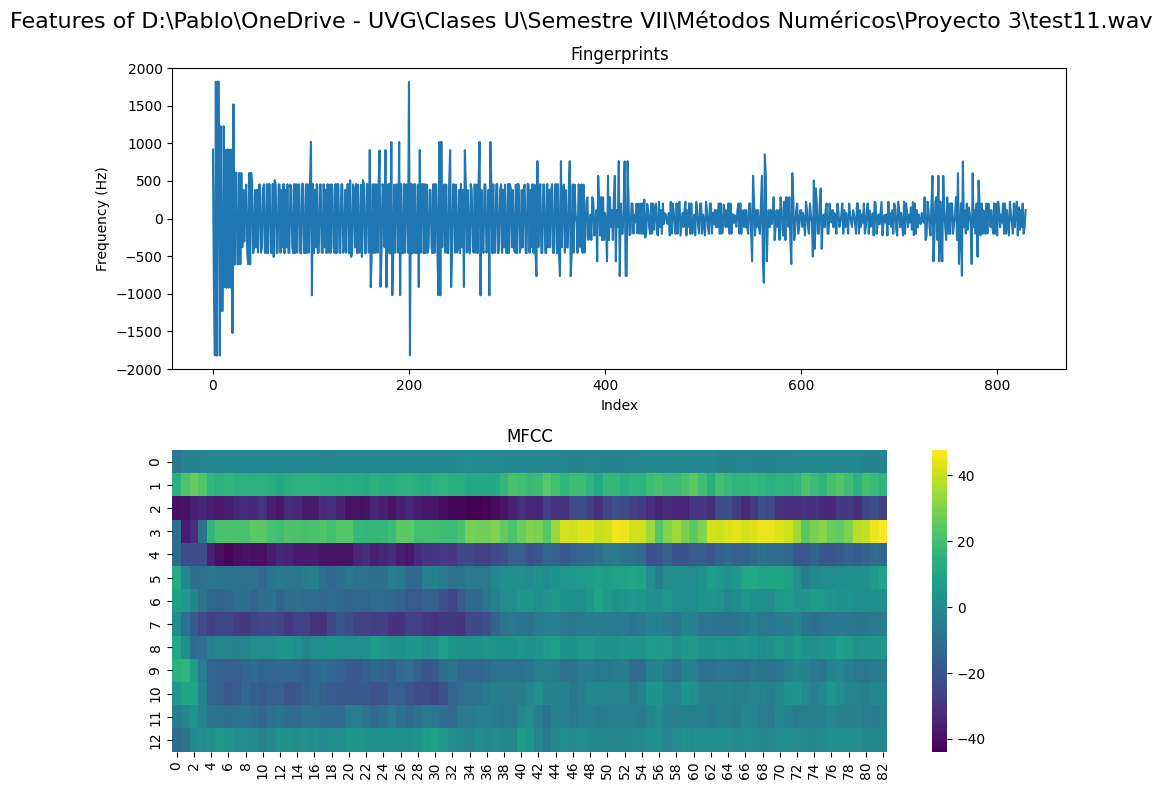

La mejor coincidencia es: Everybody-Wants-To-Rule-The-World.wav_30


In [12]:
# Archivo de audio de consulta
query_file = r'D:\Pablo\OneDrive - UVG\Clases U\Semestre VII\Métodos Numéricos\Proyecto 3\test11.wav'
# Encontrar la mejor coincidencia en la base de datos para el archivo de consulta
match = find_match(query_file, database, segment_duration=0.5, overlap=0.5, num_peaks=10)
print(f"La mejor coincidencia es: {match}")


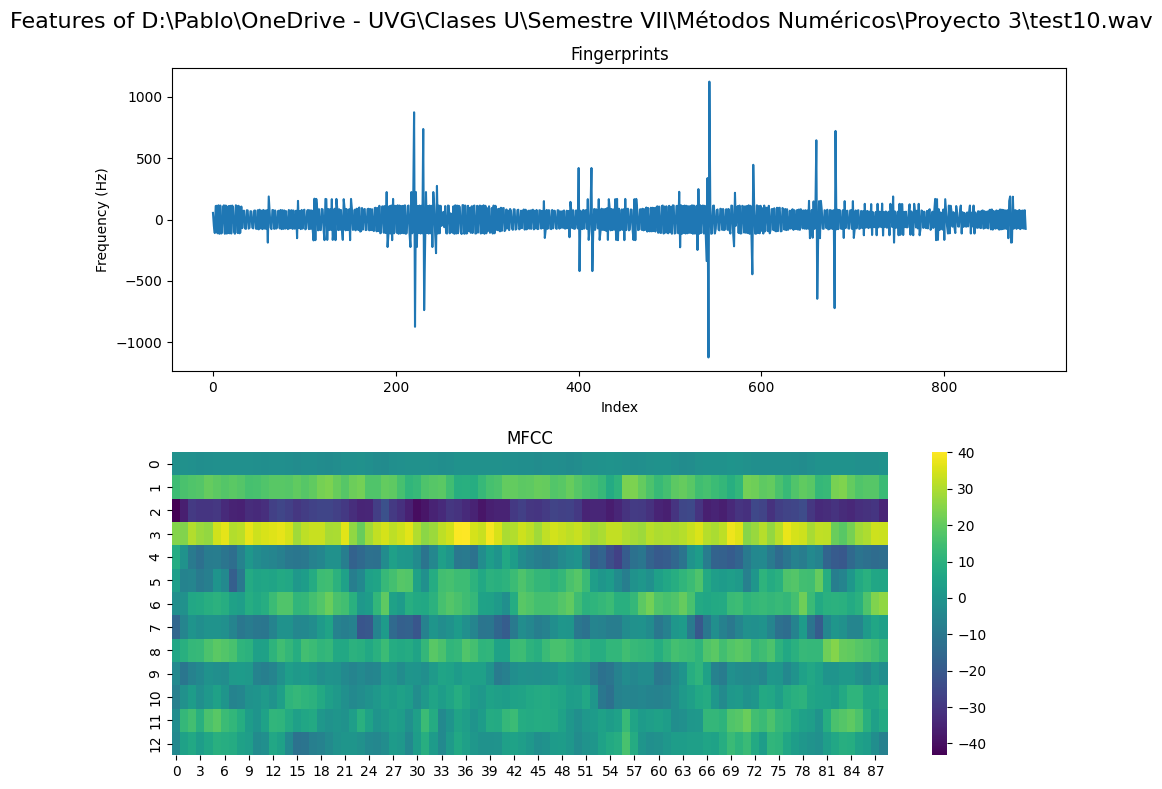

La mejor coincidencia es: The-Beatles-Here-Comes-The-Sun-_2019-Mix_.wav_126


In [13]:
# Archivo de audio de consulta
query_file = r'D:\Pablo\OneDrive - UVG\Clases U\Semestre VII\Métodos Numéricos\Proyecto 3\test10.wav'
# Encontrar la mejor coincidencia en la base de datos para el archivo de consulta
match = find_match(query_file, database, segment_duration=0.5, overlap=0.5, num_peaks=10)
print(f"La mejor coincidencia es: {match}")

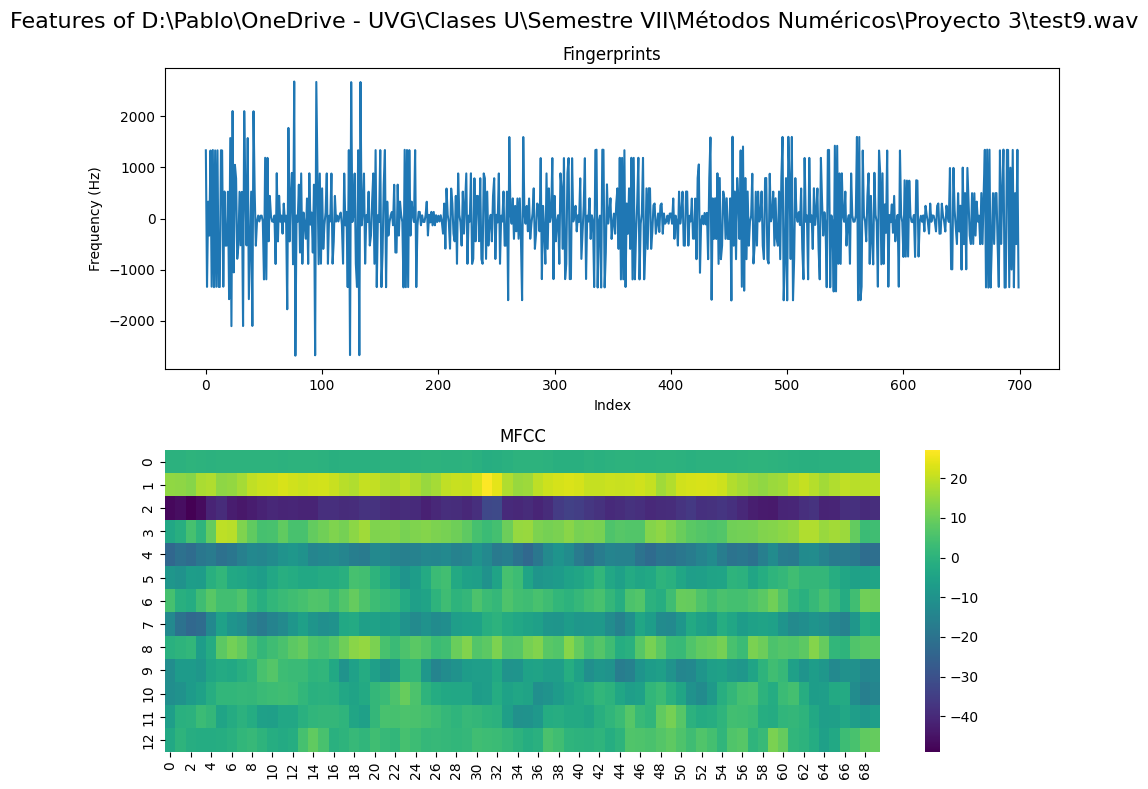

La mejor coincidencia es: Main-Theme-_Full-Version_-The-Legend-of-Zelda_-Tears-of-the-Kingdom-OST.wav_427


In [95]:
# Archivo de audio de consulta
query_file = r'D:\Pablo\OneDrive - UVG\Clases U\Semestre VII\Métodos Numéricos\Proyecto 3\test9.wav'
# Encontrar la mejor coincidencia en la base de datos para el archivo de consulta
match = find_match(query_file, database, segment_duration=0.5, overlap=0.5, num_peaks=10)
print(f"La mejor coincidencia es: {match}")

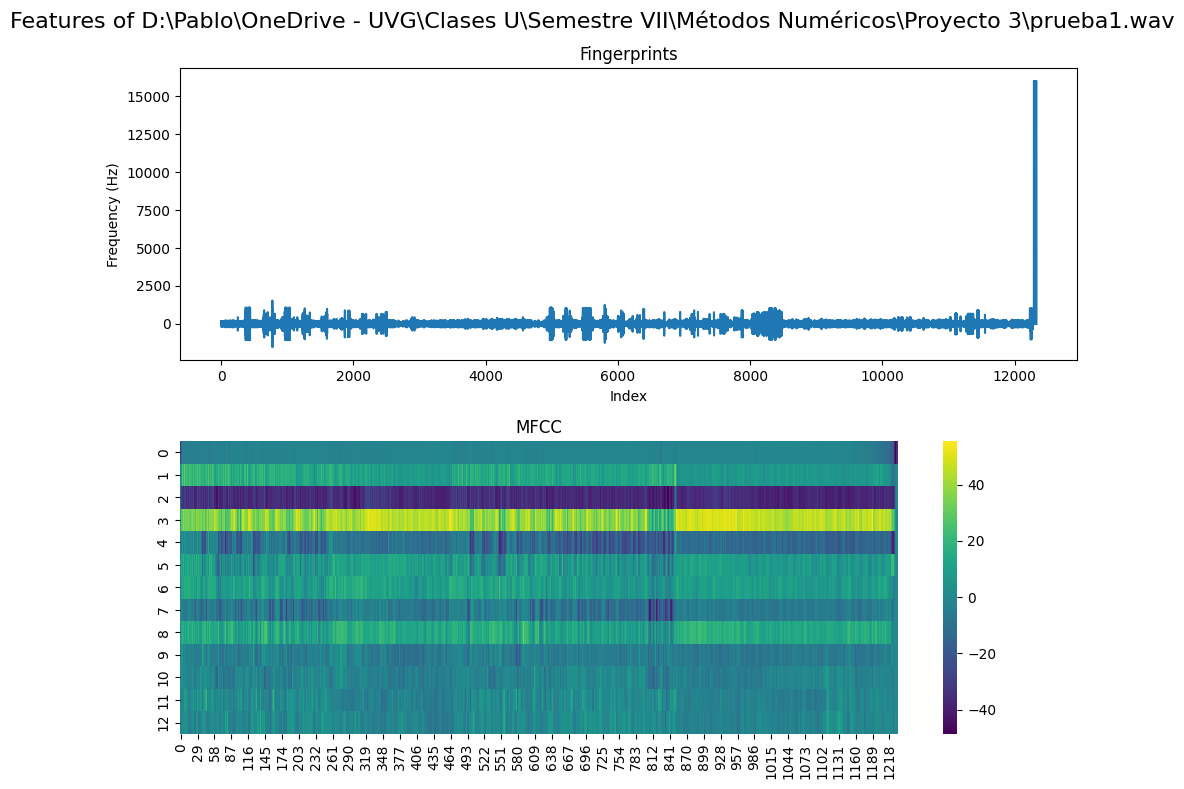

La mejor coincidencia es: Sandman.wav_0


In [96]:
# Archivo de audio de consulta
query_file = r'D:\Pablo\OneDrive - UVG\Clases U\Semestre VII\Métodos Numéricos\Proyecto 3\prueba1.wav'
# Encontrar la mejor coincidencia en la base de datos para el archivo de consulta
match = find_match(query_file, database, segment_duration=0.5, overlap=0.5, num_peaks=10)
print(f"La mejor coincidencia es: {match}")